![Adversarial example](adversarial_example.png "Adversarial example")

In [1]:
import torch.nn as nn

In [2]:
from utils import MnistData
from models import ModelManager, ModelType

In [3]:
model_loaded = ModelManager.get_trained(ModelType.MnistCnnMilano)
data = MnistData(True)

In [4]:
if data.training_images.grad is not None:
    data.training_images.grad.zero_()
loss = nn.CrossEntropyLoss()(model_loaded(data.training_images), data.training_labels)
loss.backward()
grad = data.training_images.grad

In [5]:
altered_training_images = data.training_images + 1e-1 * grad.apply_(lambda x: 1 if x >= 0 else -1)

In [6]:
altered_training_images = altered_training_images.detach()
altered_training_images.apply_(lambda x: 1 if x> 1 else (0 if x < 0 else x))  # normalize

tensor([[[[0.0000, 0.1000, 0.0000,  ..., 0.1000, 0.1000, 0.1000],
          [0.1000, 0.1000, 0.0000,  ..., 0.0000, 0.1000, 0.0000],
          [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.0000, 0.0000],
          ...,
          [0.1000, 0.0000, 0.1000,  ..., 0.1000, 0.0000, 0.1000],
          [0.1000, 0.1000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.1000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.1000, 0.1000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.1000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1000, 0.0000, 0.0000],
          [0.1000, 0.0000, 0.1000,  ..., 0.1000, 0.0000, 0.1000],
          [0.0000, 0.0000, 0.0000,  ..., 0.1000, 0.0000, 0.0000]]],


        [[[0.1000, 0.1000, 0.0000,  ..., 0.0000, 0.0000, 0.1000],
          [0.1000, 0.0000, 0.0000,  ..., 0.0000, 0.1000, 0.0000],
          [0.1000, 0.0000, 0.1000,  ..

In [7]:
def get_prediction(model, image):
    my_image = image.unsqueeze(0)
    pred = model(my_image)
    maxout = max(pred[0])
    for j in range(10):
        if pred[0, j] == maxout:
            return j, maxout

In [22]:
possible_adversarials = []
for i in range(len(data.training_images)):
    prediction, confidence = get_prediction(model_loaded, altered_training_images[i])
    original_prediction, original_confidence = get_prediction(model_loaded, data.training_images[i])
    if prediction != data.training_labels[i] and original_prediction == data.training_labels[i]:
        params = {"Label": data.training_labels[i], "Prediction": prediction, "Confidence": confidence,
                  "Index": i, "OriginalPrediction": original_prediction, "OriginalConfidence": original_confidence}
        possible_adversarials.append(params)

In [23]:
len(possible_adversarials)

12515

In [10]:
from matplotlib import pyplot as plt
import numpy as np

In [16]:
def display(image):
    first_image = image[0].reshape((28 * 28,)).detach()
    first_image = np.array(first_image, dtype='float')
    pixels = first_image.reshape((28, 28))
    plt.imshow(pixels, cmap="gray")
    plt.show()

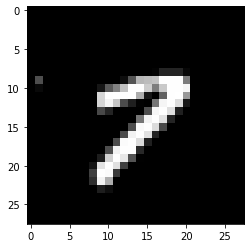

+++++


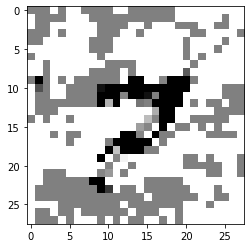

=====


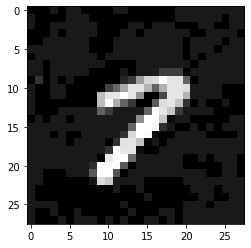

Label: 7, Prediction: 2, Confidence: 0.7377729415893555
Original prediction: 7, Original confidence: 0.9997873902320862


In [26]:
adversarial = possible_adversarials[2]
original_image = data.training_images[adversarial["Index"]]
altered_image = altered_training_images[adversarial["Index"]]
mask = altered_image - original_image
# mask = mask * 255
# original_image = original_image * 255
# altered_image = altered_image * 255
display(original_image)
print("+++++")
display(mask)
print("=====")
display(altered_image)
print(f"Label: {adversarial['Label']}, Prediction: {adversarial['Prediction']}, Confidence: {adversarial['Confidence']}")
print(f"Original prediction: {adversarial['OriginalPrediction']}, Original confidence: {adversarial['OriginalConfidence']}")